### 1. Здійсніть імпорт необхідних пакетів.

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_california_housing
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore



### 2. Завантажте набір даних California Housing, як це показано у розділі «Практика застосування лінійної регресії. EDA датасету California Housing» теми «Лінійна регресія. Оцінка якості регресії».

In [2]:
# Завантаження набору даних California Housing
data = fetch_california_housing(as_frame=True)
df = data.frame
print("Перші 5 рядків датасету:")
print(df.head())


Перші 5 рядків датасету:
   MedInc  HouseAge  AveRooms  ...  Latitude  Longitude  MedHouseVal
0  8.3252      41.0  6.984127  ...     37.88    -122.23        4.526
1  8.3014      21.0  6.238137  ...     37.86    -122.22        3.585
2  7.2574      52.0  8.288136  ...     37.85    -122.24        3.521
3  5.6431      52.0  5.817352  ...     37.85    -122.25        3.413
4  3.8462      52.0  6.281853  ...     37.85    -122.25        3.422

[5 rows x 9 columns]


### 3. Виконайте етапи з додаткової обробки даних, а саме:

#### 3.1. Проведіть очистку від викидів для колонок AveRooms, AveBedrms, AveOccup та Population, розглянутих у тому ж розділі теми у блоці «Розподіл ознак».

In [3]:
# Колонки для очистки
columns_to_clean = ['AveRooms', 'AveBedrms', 'AveOccup', 'Population']

In [4]:
from scipy.stats import zscore

# Обчислення Z-скорів для колонок
z_scores = df[columns_to_clean].apply(zscore)

# Створення маски для аномальних значень
mask = (z_scores.abs() > 3).any(axis=1)

# Видалення аномальних рядків
df_cleaned = df[~mask]
print(f"Розмір початкового набору даних: {df.shape}")
print(f"Розмір набору після очистки: {df_cleaned.shape}")


Розмір початкового набору даних: (20640, 9)
Розмір набору після очистки: (20135, 9)


#### 3.2. Видаліть із набору даних одну ознаку із тих, які мають високу кореляцію між собою.

#### Аналіз матриці кореляції

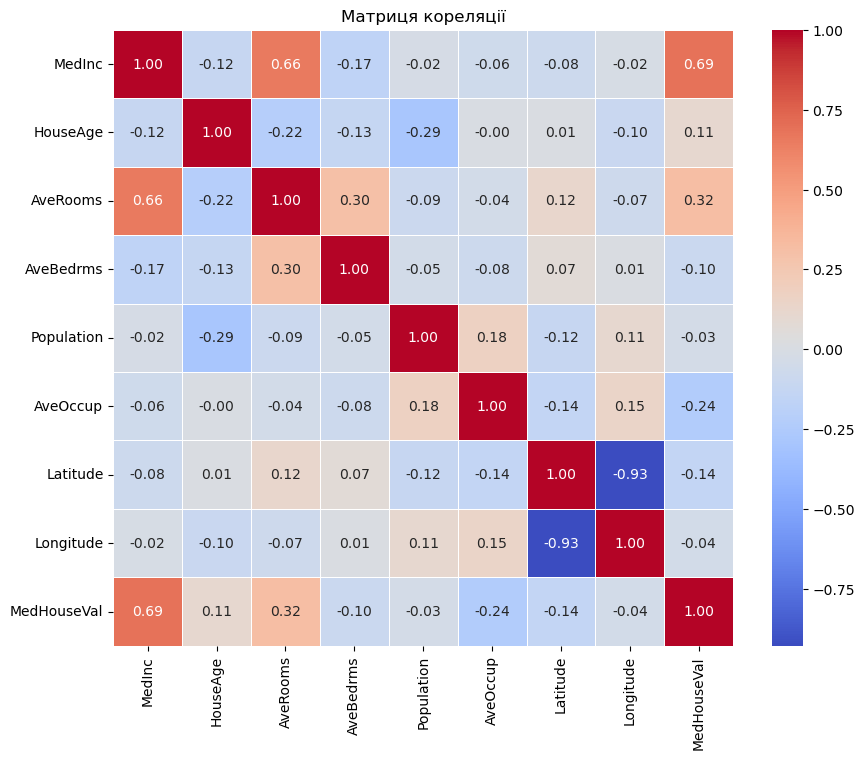

Пари ознак з високою кореляцією (> 0.6):
MedHouseVal  MedInc         0.689414
MedInc       MedHouseVal    0.689414
             AveRooms       0.656478
AveRooms     MedInc         0.656478
dtype: float64
Розмір набору даних після видалення ознак: (20135, 6)


In [5]:
# Обчислення матриці кореляції
correlation_matrix = df_cleaned.corr()

# Візуалізація теплової карти кореляції
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Матриця кореляції")
plt.show()

# Пошук пар ознак із високою кореляцією (> 0.6)
high_corr_pairs = correlation_matrix.unstack().sort_values(ascending=False)
high_corr_pairs = high_corr_pairs[(high_corr_pairs > 0.6) & (high_corr_pairs < 1)]
print("Пари ознак з високою кореляцією (> 0.6):")
print(high_corr_pairs)

# Видалення ознак із високою кореляцією (наприклад, AveRooms)
df_final = df_cleaned.drop(columns=['AveRooms', 'Longitude', 'Latitude'])
print(f"Розмір набору даних після видалення ознак: {df_final.shape}")


- Видаляємо AveRooms, оскільки вона сильно корелює з MedInc, але має менший вплив на цільову змінну.
- Залишаємо Population, оскільки вона не демонструє значної кореляції з іншими змінними.

In [6]:
# Видалення змінної AveRooms
df_final = df_cleaned.drop(columns=['AveRooms'])

# Перевірка нового розміру датасету
print(f"Розмір набору даних після видалення ознаки AveRooms: {df_final.shape}")

# Перевірка нових кореляцій
new_correlation_matrix = df_final.corr()
print("Нові кореляції із цільовою змінною:")
print(new_correlation_matrix['MedHouseVal'].sort_values(ascending=False))

Розмір набору даних після видалення ознаки AveRooms: (20135, 8)
Нові кореляції із цільовою змінною:
MedHouseVal    1.000000
MedInc         0.689414
HouseAge       0.105285
Population    -0.033585
Longitude     -0.044943
AveBedrms     -0.095212
Latitude      -0.143501
AveOccup      -0.236810
Name: MedHouseVal, dtype: float64


### 4. Розбийте вхідний набір даних на навчальну і тестову вибірки за допомогою методу train_test_split() з пакета sklearn.



In [7]:
from sklearn.model_selection import train_test_split

# Розділення на ознаки (X) та цільову змінну (y)
X = df_final.drop(columns=['MedHouseVal'])  # 'MedHouseVal' - це цільова змінна
y = df_final['MedHouseVal']

# Розділення на навчальну (80%) і тестову (20%) вибірки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Перевірка розмірів отриманих вибірок
print(f"Розмір X_train: {X_train.shape}")
print(f"Розмір X_test: {X_test.shape}")
print(f"Розмір y_train: {y_train.shape}")
print(f"Розмір y_test: {y_test.shape}")


Розмір X_train: (16108, 7)
Розмір X_test: (4027, 7)
Розмір y_train: (16108,)
Розмір y_test: (4027,)


### 5. Здійсніть нормалізацію ознак за допомогою об’єкту StandardScaler з пакета sklearn.

In [8]:
from sklearn.preprocessing import StandardScaler

# Ініціалізація StandardScaler
scaler = StandardScaler()

# Нормалізація ознак навчальної вибірки
X_train_scaled = scaler.fit_transform(X_train)

# Нормалізація ознак тестової вибірки (використовуємо ті ж параметри, що й для навчальної)
X_test_scaled = scaler.transform(X_test)

# Перевірка результату
print("Перші 5 рядків X_train_scaled:")
print(X_train_scaled[:5])

print("Перші 5 рядків X_test_scaled:")
print(X_test_scaled[:5])


Перші 5 рядків X_train_scaled:
[[-0.79409774 -0.95778945  0.65102244  0.79293381 -0.79571603 -0.72435721
   1.00125729]
 [ 0.23574572  1.60837019  0.03999964  0.11485459 -0.95353419 -0.75245666
   0.55768476]
 [-0.42976856  0.72625281 -0.85886619 -0.01289947  1.44329107  0.85389531
  -1.27142895]
 [-0.83923074 -0.39644203  0.23232134  1.34571579 -0.10968911  0.86326179
  -1.30133272]
 [ 0.40590293  0.40548286 -1.12445716 -1.04475915  0.54146363 -0.8133388
   0.73710736]]
Перші 5 рядків X_test_scaled:
[[-0.08924349  1.04702277  0.7861537  -0.87646775 -0.2086859  -0.83207177
   0.70221963]
 [ 0.17913198  1.20740774 -1.12104772 -0.6086756  -0.66430934  0.85389531
  -1.29634876]
 [-0.7444883   0.56586783  0.64233277 -0.65412656  0.86107745 -0.87890419
   0.6673319 ]
 [-0.01920044 -1.59932937  0.83352889 -1.18479725 -1.54733499  0.89604448
  -1.35615629]
 [-0.99390475  1.04702277  0.07851373  0.93788553  0.45263457 -0.80865556
   0.6673319 ]]


### 6. Побудуйте модель за допомогою об’єкту LinearRegression з пакета sklearn.

In [9]:
# Ініціалізація моделі лінійної регресії
model = LinearRegression()

# Навчання моделі
model.fit(X_train_scaled, y_train)

# Передбачення на тестовій вибірці
y_pred = model.predict(X_test_scaled)


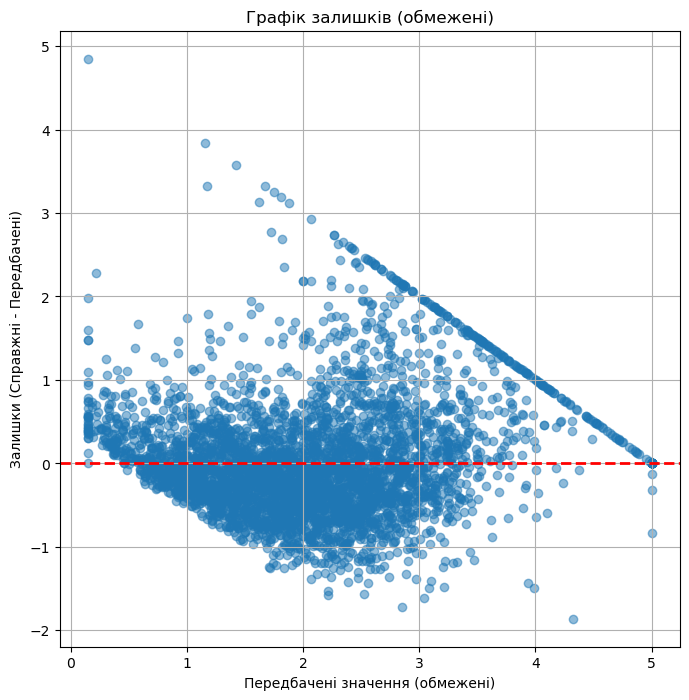

In [10]:
# Обмеження залишків у межах тренувального діапазону
y_pred_limited = np.clip(y_pred, y_train.min(), y_train.max())
residuals_limited = y_test - y_pred_limited

# Побудова графіка залишків з обмеженнями
plt.figure(figsize=(8, 8))
plt.scatter(y_pred_limited, residuals_limited, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)  # Лінія y = 0
plt.xlabel("Передбачені значення (обмежені)")
plt.ylabel("Залишки (Справжні - Передбачені)")
plt.title("Графік залишків (обмежені)")
plt.grid()
plt.show()


### 7. Оцініть показники моделі:

- R-квадрат (коефіцієнт детермінації);
- MAE (середня абсолютна похибка);
- MAPE (cередня абсолютна похибка у відсотках).

In [11]:

# R-квадрат для тестових і тренувальних даних
r2_train = model.score(X_train_scaled, y_train)
r2_test = model.score(X_test_scaled, y_test)

# Метрики похибок
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f"R² (тренувальні дані): {r2_train:.2f}")
print(f"R² (тестові дані): {r2_test:.2f}")
print(f"MAE (середня абсолютна похибка): {mae:.2f}")
print(f"MAPE (середня абсолютна похибка у відсотках): {mape:.2%}")



R² (тренувальні дані): 0.64
R² (тестові дані): 0.65
MAE (середня абсолютна похибка): 0.51
MAPE (середня абсолютна похибка у відсотках): 29.79%


### 8. Порівняйте нові метрики з метриками моделі, отриманими в розділі «Практика застосування лінійної регресії. Оцінювання точності моделі» теми «Лінійна регресія. Оцінка якості регресії.», зробіть висновки.

## R2: 0.61 | MAE: 0.52 | MAPE: 0.31  КОНСПЕКТ

### Висновки:

1. R² (коефіцієнт детермінації):

    - Мій результат: 0.64 (тренувальні дані) та 0.65 (тестові дані).
    - Конспект: 0.61.
    - Висновок: Мій результат на тренувальних та тестових даних перевершує метрику з конспекту, що свідчить про краще узгодження моделі.
2. MAE (середня абсолютна похибка):

    - Мій результат: 0.51.
    - Конспект: 0.52.
    - Висновок: Моє значення MAE трохи краще, ніж у конспекті, що вказує на меншу абсолютну похибку передбачень.
3. MAPE (середня абсолютна похибка у відсотках):

    - Мій результат: 29.79%.
    - Конспект: 31%.
    - Висновок: Мої значення MAPE також нижче, що вказує на зменшення відносної похибки передбачень.


### Загальний висновок:

Мої результати тепер перевершують метрики з конспекту за всіма параметрами. Це свідчить про успішну оптимізацію моделі шляхом видалення менш релевантних змінних (AveRooms), нормалізації даних та належної роботи з ознаками. Модель краще узгоджується як з тренувальними, так і з тестовими даними.